# 3. Regression
In this notebook we will finally run our regression models. For that purpose, we are importing the necessary libraries and functions from our ```modules``` folder. We are also importing our extracted dataframe

In [8]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy import stats
from functools import reduce

# Statsmodels
import statsmodels.api as sm
import pmdarima as pmd
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning models
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    precision_score

)

from xgboost import XGBRegressor



In [9]:
# We import our own functions
import sys
sys.path.append('../../..')  # Move two levels up to the project root
from modules.functions import *

In [10]:
df = pd.read_csv('../../../input/df_raw_h08.csv', parse_dates=['Fecha'], index_col='Fecha')
df.tail()

,CPI,CPI Tradable,CPI Non-Tradable,CPI Core,CPI Non-Core,CPI Food and Energy,CPI Excluding Food and Energy,CPI Food and Beverages,CPI Excluding Food and Beverages,CPI Core Excluding Food and Beverages,...,Wholesale Price Index,Reserve Requirement Rate,Monetary Policy Rate,Circulating Currency Seasonally Adjusted (mill S/),Net International Reserves (mill $),Real Minimum Wage (Index),Wheat (US$ per ton),Corn (US$ per ton),Soybean oil (US$ per ton),Crude oil (US$ per barrel)
Fecha,,,,,,,,,,,,,,,,,,,,,
2008-08-01,0.554025,0.356039,0.690723,0.469680,0.666096,0.681738,0.394014,0.755351,0.365874,0.317970,...,0.702300,11.472876,6.25,0.005009,0.002124,-0.005870,-0.012197,-0.160701,-0.156075,-0.128561
2008-09-01,0.565199,0.336413,0.723117,0.481624,0.675909,0.680067,0.422250,0.754096,0.388973,0.335349,...,0.693072,10.787601,6.50,0.017596,-0.006157,-0.005640,-0.125494,-0.006954,-0.078231,-0.103871
2008-10-01,0.576337,0.316247,0.755818,0.493295,0.686014,0.678143,0.450790,0.752209,0.412633,0.352862,...,0.682759,11.862506,6.50,0.003966,-0.079794,-0.006094,-0.206207,-0.260785,-0.244475,-0.267189
2008-11-01,0.587490,0.295514,0.788926,0.504673,0.696555,0.676114,0.479560,0.749865,0.436787,0.370484,...,0.671225,10.084114,6.50,0.006653,-0.030157,-0.003081,0.021940,-0.090908,-0.102564,-0.253950
2008-12-01,0.598682,0.274156,0.822524,0.515746,0.707608,0.674121,0.508447,0.747301,0.461270,0.388144,...,0.658290,12.516334,6.50,-0.005561,0.007297,-0.003589,-0.012756,-0.010237,-0.077524,-0.287431


In [11]:
df_lags = pd.read_csv('../../../input/df_lags_h08.csv', parse_dates=['Fecha'], index_col='Fecha')
df_lags.tail()

,CPI,CPI Tradable_lag_1,CPI Tradable_lag_2,CPI Non-Tradable_lag_1,CPI Non-Tradable_lag_2,CPI Core_lag_1,CPI Core_lag_2,CPI Non-Core_lag_1,CPI Non-Core_lag_2,CPI Food and Energy_lag_1,...,Real Minimum Wage (Index)_lag_1,Real Minimum Wage (Index)_lag_2,Wheat (US$ per ton)_lag_1,Wheat (US$ per ton)_lag_2,Corn (US$ per ton)_lag_1,Corn (US$ per ton)_lag_2,Soybean oil (US$ per ton)_lag_1,Soybean oil (US$ per ton)_lag_2,Crude oil (US$ per barrel)_lag_1,Crude oil (US$ per barrel)_lag_2
Fecha,,,,,,,,,,,,,,,,,,,,,
2008-08-01,0.554025,0.375112,0.393584,0.658619,0.626801,0.457492,0.445103,0.656495,0.646992,0.683126,...,-0.005524,-0.007637,-0.059006,0.021662,-0.085210,0.169325,-0.030379,0.055625,0.000075,0.065257
2008-09-01,0.565199,0.356039,0.375112,0.690723,0.658619,0.469680,0.457492,0.666096,0.656495,0.681738,...,-0.005870,-0.005524,-0.012197,-0.059006,-0.160701,-0.085210,-0.156075,-0.030379,-0.128561,0.000075
2008-10-01,0.576337,0.336413,0.356039,0.723117,0.690723,0.481624,0.469680,0.675909,0.666096,0.680067,...,-0.005640,-0.005870,-0.125494,-0.012197,-0.006954,-0.160701,-0.078231,-0.156075,-0.103871,-0.128561
2008-11-01,0.587490,0.316247,0.336413,0.755818,0.723117,0.493295,0.481624,0.686014,0.675909,0.678143,...,-0.006094,-0.005640,-0.206207,-0.125494,-0.260785,-0.006954,-0.244475,-0.078231,-0.267189,-0.103871
2008-12-01,0.598682,0.295514,0.316247,0.788926,0.755818,0.504673,0.493295,0.696555,0.686014,0.676114,...,-0.003081,-0.006094,0.021940,-0.206207,-0.090908,-0.260785,-0.102564,-0.244475,-0.253950,-0.267189


## 3.1 Benchmark models

In the first section, we first run our benchmark econometric models: ```Random Walk (RW)```,  ```Autoregressive Integrated Moving Average (ARIMA)``` and ```Vector Autoregression (VAR)``` processes

In [12]:
def get_RMSE(results):
    '''
    Objective:
        This function receives a DataFrame with both Actual and Predicted values and calculates the RMSE
        for each row.
        
    Input:
        results (DataFrame): DataFrame with 'Actual' and 'Predicted' columns.
        
    Output:
        A list containing RMSE for each row.
    '''
    RMSE = []

    for index, row in results.iterrows():
        sqr_err = (row['Actual'] - row['Predicted']) ** 2
        rmse = np.sqrt(sqr_err)
        RMSE.append(rmse)

    return RMSE

def get_MAPE(results):
    '''
    Objective:
        This function receives a DataFrame with both Actual and Predicted values and calculates the MAPE
        for each row.
        
    Input:
        results (DataFrame): DataFrame with 'Actual' and 'Predicted' columns.
        
    Output:
        A list containing MAPE for each row.
    '''
    MAPE = []

    for index, row in results.iterrows():
        per_err = abs((row['Actual'] - row['Predicted']) / row['Actual'])
        MAPE.append(per_err)

    return MAPE



### 3.1.1 Random Walk (RW)

In [13]:
forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# We define our target variable
target = 'CPI'

# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2008-01-01']
test_set  = df_CPI[df_CPI.index >= '2008-01-01']

predictions = {}

for h in forecast_horizons:
    # We get the values h horizons before
    predicted_value = train_set.iloc[-h, 0] + train_set.std()[0]

    # We save it for horizon h
    predictions[h] = predicted_value

predicted = pd.DataFrame([predictions]).transpose().reset_index()

predicted.columns = ['Horizon', 'Prediction']

predicted = predicted.set_index(test_set.index)

predicted

,Horizon,Prediction
Fecha,,
2008-01-01,1,0.576846
2008-02-01,2,0.560624
2008-03-01,3,0.539355
2008-04-01,4,0.513236
2008-05-01,5,0.482750
2008-06-01,6,0.449230
2008-07-01,7,0.414719
2008-08-01,8,0.381859
2008-09-01,9,0.351194


In [14]:
# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'Horizon': 'Horizon', 'Prediction': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results

,Horizon,Predicted,Actual
Fecha,,,
2008-01-01,1,0.576846,0.474129
2008-02-01,2,0.560624,0.485227
2008-03-01,3,0.539355,0.496869
2008-04-01,4,0.513236,0.508551
2008-05-01,5,0.482750,0.520097
2008-06-01,6,0.449230,0.531498
2008-07-01,7,0.414719,0.542800
2008-08-01,8,0.381859,0.554025
2008-09-01,9,0.351194,0.565199


In [15]:
# We get our metrics using our function
RMSE_rw, MAPE_rw = get_metrics(results, 'RW')
metrics_rw = pd.concat([RMSE_rw, MAPE_rw], axis = 1)
metrics_rw

,RMSE_RW,MAPE_RW
1,0.102716,0.216642
2,0.090098,0.186013
3,0.077546,0.152511
4,0.067198,0.116687
5,0.062381,0.107711
6,0.066113,0.115557
7,0.078038,0.132758
8,0.095047,0.155007
9,0.114537,0.179855
10,0.135498,0.206285


### 3.1.2 Autoregressive Integrated Moving Average (ARIMA)

In [16]:
# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2008-01-01']
test_set  = df_CPI[df_CPI.index >= '2008-01-01']

In [17]:
# We find the best SARIMA model
autoarima = pmd.auto_arima(
        y = train_set,
        start_p=1,
        start_q=0,
        seasonal=True,
        max_p=12,
        max_d=1,
        max_q=6,
        max_P=12,
        max_D=1,
        max_Q=6,
        m=4,
        n_jobs=-1,
        suppress_warnings=True,
        )

# We indicate the seasonal order for monthly data
seasonal_order = (1, 1, 1, 12)

# We create our ARIMA model
model = SARIMAX(train_set,
                order=autoarima.order,
                seasonal_order=autoarima.seasonal_order,
                enforce_stationarity = False,
                enforce_invertibility = False)
        
# We fit the model
model_fit = model.fit()

# We forecast for the next 12 horizons
forecast_values = model_fit.get_forecast(steps=12)
predicted = pd.DataFrame(forecast_values.predicted_mean, index = test_set.index)

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'predicted_mean': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2008-01-01,0.473018,0.474129
2008-02-01,0.479630,0.485227
2008-03-01,0.483583,0.496869
2008-04-01,0.486860,0.508551
2008-05-01,0.490173,0.520097
2008-06-01,0.493535,0.531498
2008-07-01,0.497540,0.542800
2008-08-01,0.502839,0.554025
2008-09-01,0.509217,0.565199


In [18]:
# We get our metrics using our function
RMSE_arima, MAPE_arima = get_metrics(results, 'ARIMA')
metrics_arima= pd.concat([RMSE_arima, MAPE_arima], axis = 1)
metrics_arima

,RMSE_ARIMA,MAPE_ARIMA
1,0.001111,0.002343
2,0.004035,0.006939
3,0.008348,0.013539
4,0.013034,0.020817
5,0.017748,0.028161
6,0.022421,0.035372
7,0.026898,0.042230
8,0.030993,0.048500
9,0.034671,0.054117
10,0.038001,0.059148


### 3.1.3 Vector autoregression (VAR)

In [19]:
# We define our target variable, as well as our train and test set
target = 'CPI'
train_set = df[df.index < '2008-01-01']
test_set  = df[df.index >= '2008-01-01']

In [20]:
# We model our VAR including up to two lags
model_var = VAR(df)
model_fit = model_var.fit(2)

In [21]:
# We forecast for the next 12 months
preds = model_fit.forecast(df.values[-2:], 12)
preds = pd.DataFrame(preds, index = test_set[target].index)[0]

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([preds, test_set[target]],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2008-01-01,0.609283,0.474129
2008-02-01,0.619292,0.485227
2008-03-01,0.628872,0.496869
2008-04-01,0.638122,0.508551
2008-05-01,0.647500,0.520097
2008-06-01,0.657306,0.531498
2008-07-01,0.667995,0.542800
2008-08-01,0.679647,0.554025
2008-09-01,0.692975,0.565199


In [22]:
# We get our metrics using our function
RMSE_var, MAPE_var = get_metrics(results, 'VAR')
metrics_var= pd.concat([RMSE_var, MAPE_var], axis = 1)
metrics_var

,RMSE_VAR,MAPE_VAR
1,0.135154,0.285056
2,0.134610,0.280675
3,0.133747,0.275673
4,0.132715,0.270451
5,0.131670,0.265353
6,0.130711,0.260578
7,0.129938,0.256302
8,0.129406,0.252607
9,0.129226,0.249659
10,0.129542,0.247659


<Axes: >

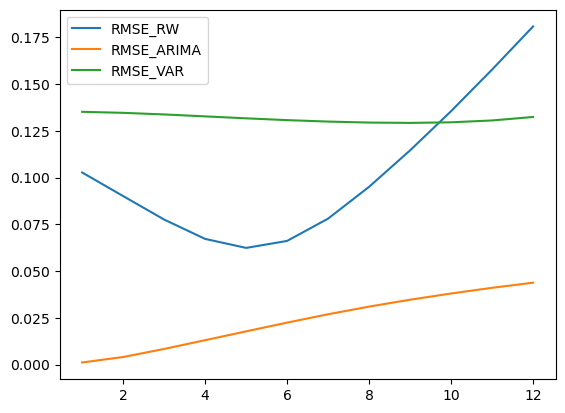

In [23]:
rmse_econometrics = pd.concat([RMSE_rw, RMSE_arima, RMSE_var], axis=1)

rmse_econometrics.plot()

## 3.2 Machine learning models

In the second section, we run our machine learning models: ```Ridge Regression (Ridge)```,  ```Least Absolute Shrinkage and Selection Operator (LASSO)``` and ```Random Forest (RF)``` models

### 3.2.1 Ridge Regression (Ridge)

In [25]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2, test_size= 12)

# We implement the model
import sklearn.linear_model as skl
ridge = skl.ElasticNet(l1_ratio=0)
model = ridge

# We define out lambdas and implement our gridparams
lambdas    = np.linspace(0.0001, 1, 1000)

grid_params = {'alpha': lambdas}

# We implement our gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')

grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [27]:
# We use the best model to predict
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)
y_pred

Fecha
2008-01-01    0.469864
2008-02-01    0.478197
2008-03-01    0.486769
2008-04-01    0.494961
2008-05-01    0.501813
2008-06-01    0.510479
2008-07-01    0.519535
2008-08-01    0.528825
2008-09-01    0.537004
2008-10-01    0.544017
2008-11-01    0.551577
2008-12-01    0.557662
dtype: float64

In [28]:
# And concatenate the results
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2008-01-01,0.469864,0.474129
2008-02-01,0.478197,0.485227
2008-03-01,0.486769,0.496869
2008-04-01,0.494961,0.508551
2008-05-01,0.501813,0.520097
2008-06-01,0.510479,0.531498
2008-07-01,0.519535,0.542800
2008-08-01,0.528825,0.554025
2008-09-01,0.537004,0.565199


In [29]:
RMSE_ridge, MAPE_ridge = get_metrics(results, 'Ridge')

<Axes: >

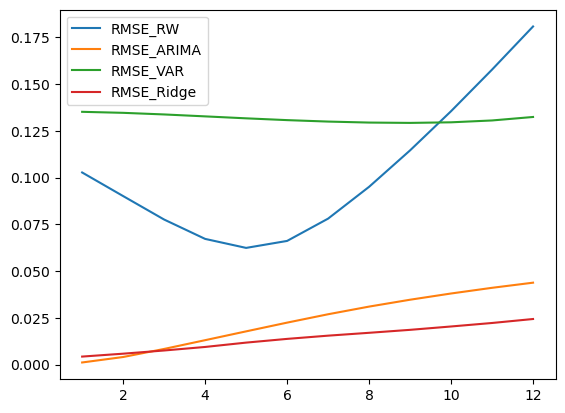

In [30]:
pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge], axis=1).plot()

### 3.2.2 Lasso Regression (Lasso)

In [31]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
import sklearn.linear_model as skl
lasso = skl.ElasticNet( l1_ratio=1, random_state = 2024 )
model = lasso

# We implement the gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')
grid_search.fit( X_train, y_train )
pd.DataFrame( grid_search.cv_results_ )

best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [32]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)


In [33]:
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2008-01-01,0.452707,0.474129
2008-02-01,0.448203,0.485227
2008-03-01,0.444824,0.496869
2008-04-01,0.437793,0.508551
2008-05-01,0.430350,0.520097
2008-06-01,0.425446,0.531498
2008-07-01,0.421874,0.542800
2008-08-01,0.417770,0.554025
2008-09-01,0.412708,0.565199


In [34]:
RMSE_lasso, MAPE_lasso = get_metrics(results, 'Lasso')

<Axes: >

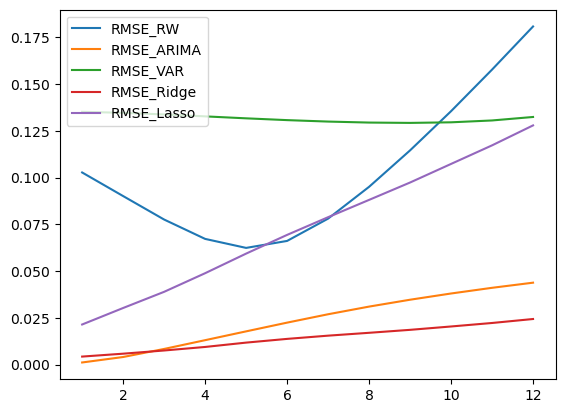

In [35]:
pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge, RMSE_lasso], axis=1).plot()

### 3.2.3 Random Forest Regression (Random Forest)

In [45]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2, test_size= 12)

# We implement the model
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor( random_state = 2024, n_jobs = -1 )
model = random_forest

# We define out lambdas and implement our gridparams
n_estimators = [5, 6, 10, 12, 15]

max_depth = [10, 20, 30, 50]

grid_params = {'n_estimators': n_estimators, 'max_depth': max_depth}

# We implement our gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')

grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [46]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [108]:
type(best_model)

sklearn.ensemble._forest.RandomForestRegressor

In [114]:
best_model.feature_importances_

array([2.44736489e-02, 8.78730810e-02, 1.61297017e-04, 1.31559515e-01,
       1.82137479e-01, 1.59536293e-03, 4.97900336e-02, 1.37600283e-03,
       1.77418521e-03, 3.32091023e-01, 1.79567628e-01, 2.30399587e-04,
       1.09408279e-05, 3.42803957e-03, 4.69069190e-04, 2.87956544e-04,
       1.26842401e-03, 8.84240163e-04, 5.17298266e-04, 5.04374691e-04])

In [47]:
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2008-01-01,0.444573,0.474129
2008-02-01,0.405256,0.485227
2008-03-01,0.340532,0.496869
2008-04-01,0.337352,0.508551
2008-05-01,0.344850,0.520097
2008-06-01,0.344000,0.531498
2008-07-01,0.347886,0.542800
2008-08-01,0.348151,0.554025
2008-09-01,0.344461,0.565199


In [40]:
RMSE_rf, MAPE_rf = get_metrics(results, 'RF')

<Axes: >

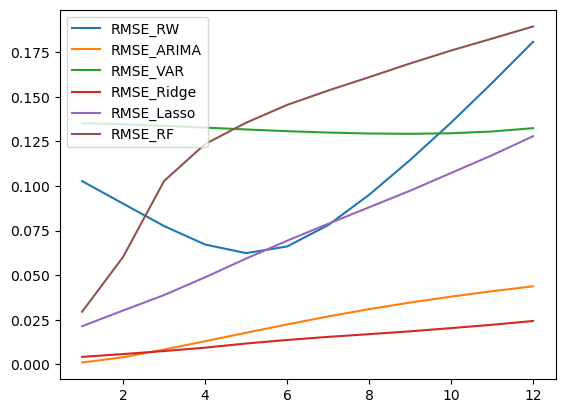

In [41]:
pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge, RMSE_lasso, RMSE_rf], axis=1).plot()

<Axes: >

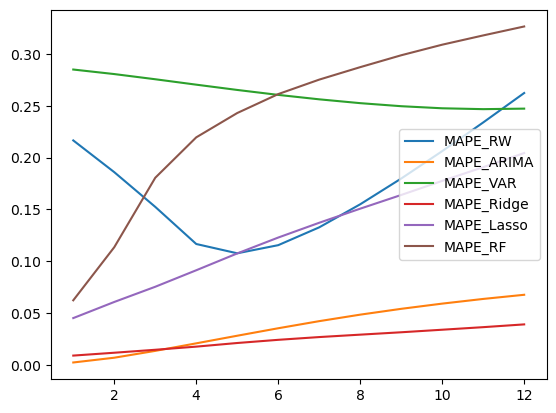

In [42]:
pd.concat([MAPE_rw, MAPE_arima, MAPE_var, MAPE_ridge, MAPE_lasso, MAPE_rf], axis=1).plot()

In [99]:
RMSE_2008.div(RMSE_rw['RMSE_RW'], axis=0)

,RMSE_RW,RMSE_ARIMA,RMSE_VAR,RMSE_Ridge,RMSE_Lasso,RMSE_RF
horizon,,,,,,
1,1.0,0.010816,1.315793,0.041523,0.208562,0.287742
2,1.0,0.044786,1.494044,0.064534,0.335712,0.669124
3,1.0,0.107651,1.724733,0.096962,0.501569,1.325793
4,1.0,0.193967,1.974987,0.140057,0.726950,1.838005
5,1.0,0.284509,2.110732,0.188122,0.951068,2.171290
6,1.0,0.339133,1.977103,0.207615,1.048789,2.199621
7,1.0,0.344680,1.665045,0.198023,1.009799,1.966631
8,1.0,0.326086,1.361497,0.178654,0.926481,1.693467
9,1.0,0.302704,1.128242,0.162080,0.849919,1.472450


In [102]:
RMSE_2008_results = RMSE_2008.div(RMSE_rw['RMSE_RW'], axis=0)
RMSE_2008_results = RMSE_2008_results.drop(columns=['RMSE_RW'])
RMSE_2008_results

,RMSE_ARIMA,RMSE_VAR,RMSE_Ridge,RMSE_Lasso,RMSE_RF
horizon,,,,,
1,0.010816,1.315793,0.041523,0.208562,0.287742
2,0.044786,1.494044,0.064534,0.335712,0.669124
3,0.107651,1.724733,0.096962,0.501569,1.325793
4,0.193967,1.974987,0.140057,0.726950,1.838005
5,0.284509,2.110732,0.188122,0.951068,2.171290
6,0.339133,1.977103,0.207615,1.048789,2.199621
7,0.344680,1.665045,0.198023,1.009799,1.966631
8,0.326086,1.361497,0.178654,0.926481,1.693467
9,0.302704,1.128242,0.162080,0.849919,1.472450


<Axes: xlabel='horizon'>

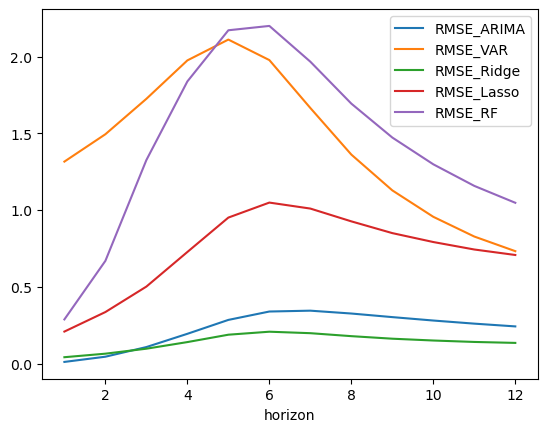

In [101]:
RMSE_2008_results.plot()

### Previous code

In [33]:
models = {
    
    'Lasso'        : { 'model'      : Lasso( random_state = 2023 ),
                       'grid_params': { 'alpha': [ 0.0001, 0.001, 0.01, 0.1 ] } },
    
    'Ridge'        : { 'model'      : Ridge( random_state = 2023 ),
                       'grid_params': { 'alpha': [ 0.0001, 0.001, 0.01, 0.1 ] } },
    
    'Elastic Net'  : { 'model'      : ElasticNet( random_state = 2023 ),
                       'grid_params': { 'alpha': [ 0.0001, 0.001, 0.01, 0.1 ], 'l1_ratio': np.arange(0.0, 1.0, 0.1) } },
    
    'Random Forest': { 'model'      : RandomForestRegressor( random_state = 2023, n_jobs = -1 ),
                       'grid_params': { 'n_estimators': [ 50, 100, 150, 200 ], 'max_depth': [10, 20, 30, 50] } },
    
    'Gradient Boosting': { 'model'  : XGBRegressor( random_state = 2023, n_jobs = -1 ),
                       'grid_params': { 'n_estimators': [ 50, 100, 150, 200 ], 'max_depth': [10, 20, 30, 50] } }
    
        }

In [34]:
# We define our target variable, as well as our train and test set
# ==============================================================================
steps = 12
target = 'CPI'
train_set = df_lags[:-steps]
test_set  = df_lags[-steps:]

In [35]:
y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

In [36]:
pred_vars = X_train.columns.to_list()

In [37]:
print(f"Training and tuning models...")

results = {
    'Model': [],
    'R2_train': [],
    'R2_test': [],
    'MAE_train': [],
    'MAE_test': [],
    'MAPE_train': [],
    'MAPE_test': [],
    'MSE_train': [],
    'MSE_test': [],
    'RMSE_train': [],
    'RMSE_test': [],
    'Grid_Search_Params': []
}

for model_name, model_params in models.items():
    print(f"Processing model: {model_name}")

    if 'model' in model_params:
        model = model_params['model']
    else:
        raise ValueError(f'Model is not defined for {model_name}')

    if 'grid_params' in model_params:
        grid_params = model_params['grid_params']
    else:
        grid_params = None

    best_params = None

    grid_search = GridSearchCV(model, grid_params, cv=tscv)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    if hasattr( best_model, 'feature_importances_' ):

        feature_importances = best_model.feature_importances_
        vars_df             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
        vars_df             = vars_df.reindex( vars_df[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
        vars_df.to_excel( f'../../../output/3_Regression/varlist__{ model_name }.xlsx' )

    elif hasattr( best_model, 'coef_' ):

        coefficients = best_model.coef_[ 0 ]
        vars_df      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
        vars_df      = vars_df.reindex( vars_df[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
        vars_df.to_excel( f'../../../output/3_Regression/varlist_{ model_name }.xlsx' )
    else:
        best_model = model.fit(X_train, y_train)
        coefficients = best_model.coef_[ 0 ]
        vars_df      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
        vars_df      = vars_df.reindex( vars_df[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
        vars_df.to_excel( f'../../../output/3_Regression/varlist_{ model_name }.xlsx' )

        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
        
        results = pd.concat([y_pred_test, y_test],axis=1)
        
        RMSE_test, MAPE_test = get_metrics(results, f'{model_name}')

        best_model_params = {
            'Model': model_name,
            'MAPE_test': MAPE_test,
            'RMSE_test': RMSE_test,
            'Grid_Search_Params': best_params
        }

        results['Model'].append(best_model_params['Model'])
        results['MAPE_test'].append(best_model_params['MAPE_test'])
        results['RMSE_test'].append(best_model_params['RMSE_test'])
        results['Grid_Search_Params'].append(best_model_params['Grid_Search_Params'])
        
print('Done')

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='RMSE_test', ascending=True)


Training and tuning models...
Processing model: Lasso
Processing model: Ridge
Processing model: Elastic Net
Processing model: Random Forest
Processing model: Gradient Boosting
Done


In [38]:
# forecaster = ForecasterAutoregMultiVariate(
#                  regressor = RandomForestRegressor(random_state=42),
#                  lags      = 2, # This value will be replaced in the grid search,
#     level = target,
#     steps = 2
#              )

# forecaster.fit()

# # Candidate values for lags
# lags_grid = [10, 20]

# # Candidate values for regressor's hyperparameters
# param_grid = {
#     'n_estimators': [100, 500],
#     'max_depth': [3, 5, 10]
# }

# results_grid = grid_search_forecaster(
#                    forecaster         = forecaster,
#                    y                  = test_set[target],
#                    level              = target,
#                    steps              = 2,
#                    param_grid         = param_grid,
#                    lags_grid          = lags_grid,
#                    steps              = steps,
#                    refit              = False,
#                    metric             = 'mean_squared_error',
#                    initial_train_size = 11,
#                    fixed_train_size   = False,
#                    return_best        = True,
#                    n_jobs             = 'auto',
#                    verbose            = False
#                )

In [39]:
# def test_models_regression(models, data, pred_vars, target_var ):
#     """
#     Evalúa modelos de regresión utilizando validación cruzada en series temporales.

#     Parámetros:
#     - modelos: Diccionario de modelos de regresión para evaluar.
#     - datos: DataFrame que contiene el conjunto de datos.
#     - variables_predictoras: Lista de nombres de variables predictoras.
#     - variable_objetivo: Nombre de la variable objetivo.

#     Retorna:
#     DataFrame: Resultados de la evaluación del modelo.
#     """       
#     results = {
#         'Model': [],
#         'R2_train': [],
#         'R2_test': [],
#         'MAE_train': [],
#         'MAE_test': [],
#         'MAPE_train': [],
#         'MAPE_test': [],
#         'MSE_train': [],
#         'MSE_test': [],
#         'RMSE_train': [],
#         'RMSE_test': [],
#         'Grid_Search_Params': []
#     }
    
#     X = data[pred_vars]
#     y = data[target_var]
    
#     cv = TimeSeriesSplit(n_splits=5)
    
#     print(f"Entrenando y evaluando modelos...")
    
#     for model_name, model_params in models.items():
#         print(f"Procesando el modelo: {model_name}")
        
#         if 'model' in model_params:
#             model = model_params['model']
#         else:
#             raise ValueError(f'Model is not defined for {model_name}')
        
#         if 'grid_params' in model_params:
#             grid_params = model_params['grid_params']
#         else:
#             grid_params = None
        
#         best_params = None
        
#         for ii, (tr, tt) in enumerate(cv.split(X, y)):
#             X_train, X_test = X.iloc[tr], X.iloc[tt]
#             y_train, y_test = y.iloc[tr], y.iloc[tt]
            
#             if ii == (cv.n_splits - 1):
            
#                 if grid_params is not None:
#                     grid_search = GridSearchCV(model, grid_params, cv=cv)
#                     grid_search.fit(X_train, y_train)
#                     best_model = grid_search.best_estimator_
#                     best_params = grid_search.best_params_

#                     if hasattr( best_model, 'feature_importances_' ):

#                         feature_importances = best_model.feature_importances_
#                         vars_df             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
#                         vars_df             = vars_df.reindex( vars_df[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
#                         vars_df.to_excel( f'varlist__{ model_name }.xlsx' )

#                     elif hasattr( best_model, 'coef_' ):

#                         coefficients = best_model.coef_[ 0 ]
#                         vars_df      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
#                         vars_df      = vars_df.reindex( vars_df[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
#                         vars_df.to_excel( f'varlist_{ model_name }.xlsx' )
#                 else:
#                     best_model = model.fit(X_train, y_train)
#                     coefficients = best_model.coef_[ 0 ]
#                     vars_df      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
#                     vars_df      = vars_df.reindex( vars_df[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
#                     vars_df.to_excel( f'varlist_{ model_name }.xlsx' )

#                 y_pred_train = best_model.predict(X_train)
#                 y_pred_test = best_model.predict(X_test)

#                 best_model_params = {
#                     'Model': model_name,
#                     'Grid_Search_Params': best_params
#                 }

#         results['Model'].append(best_model_params['Model'])
#         results['Grid_Search_Params'].append(best_model_params['Grid_Search_Params'])
    
#     results_df = pd.DataFrame(results)
#     results_df = results_df.sort_values(by='RMSE_test', ascending=True)

#     return results_df